# Regression losses

In this notebook you'll explore three regression loss functions: *mse*, *mae* and *mape*.

First some imports.

In [18]:
import numpy as np
import math
import matplotlib.pyplot as plt
try:
    plt.style.use("seaborn-v0_8")
except:
    plt.style.use("seaborn")

## Convenience code

This section contains data generation and plotting code. **Don't look at it -- simply skip to the next section.**

In [19]:
def rand_data(N,seed=42):
    np.random.seed(seed)
    x=np.random.normal(size=N)
    y=2.3*x+0.2+np.random.normal(size=N)
    return x,y

def add_outlier(x,y):
    N=len(y)
    xx=np.empty(N+1)
    xx[:N]=x.copy()
    xx[N]=1.1
    yy=np.empty(N+1)
    yy[:N]=y.copy()
    yy[N]=8
    return xx,yy

def rand_data_outlier(N,seed=42):
    return add_outlier(*rand_data(N,seed=seed))

def rand_data2(N,seed=42):
    np.random.seed(seed)
    N=N//2
    x1=np.random.random(size=N)*2+1
    x2=np.random.random(size=N)*2+11
    y1=2.3*x1+0.2+np.random.random(size=N)-0.5
    y2=2.3*x2+0.2+np.random.random(size=N)*20-5

    return np.hstack([x1,x2]),np.hstack([y1,y2])

def rand_data3(N,seed=42,small=10):
    np.random.seed(seed)
    x=np.empty(N)
    y=np.empty(N)
    x[:-small]=np.random.random(size=N-small)*10
    y[:-small]=np.abs(2.3*x[:-small]+0.5+2*np.random.random(size=N-small)-1)
    x[-small:]=np.random.random(size=small)*0.01
    y[-small:]=np.random.random(size=small)*0.01
    return x,y

def plot_data(x,y,ax=None):
    if ax is None:
        fig,ax=plt.subplots(figsize=(6,4))
    ax.scatter(x,y,color='b',edgecolor='k',alpha=0.5,s=10,zorder=10)
    return ax

def plot_fits(ax,*args):
    xx=np.array(ax.get_xlim())
    for arg in args:
        a,b,label=arg
        ax.plot(xx,a*xx+b,linewidth=2,label=label,alpha=0.8)
    ax.legend()

def plot_errors(*args,cols=4):
    n=len(args)
    rows=math.ceil(n/cols)
    if n<cols:
        cols=n
    fig,axs=plt.subplots(rows,cols,figsize=(cols*3,rows*3))
    for arg,ax in zip(args,axs.flat):
        errors,label=arg
        ax.hist(errors,edgecolor='k')
        ax.set_title("histogram "+label+" errors")
        ax.set_ylabel("count")
        ax.set_xlabel("error")

## A first fit

The function <code>rand_data</code> returns some sample data. We can easily plot it with the function <code>plot_data</code> that I've provided above. The function returns <code>ax</code>, a handle to the current plot. We'll need to pass that around later on.

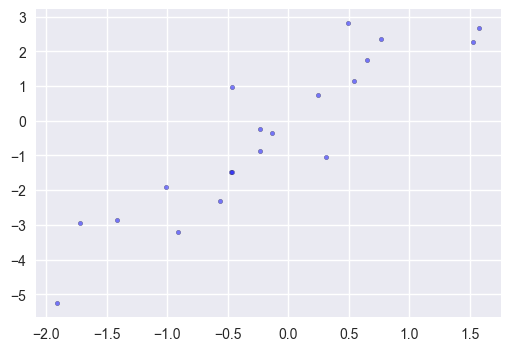

In [20]:
x,y=rand_data(20)
ax=plot_data(x,y)

So, let's do a linear regression with mse loss function. Fortunately, *scikit-learn* implements a corresponding class that we can use. For convenience, I've wrapped that into function that returns the two fit parameters <code>a,b</code> that describe the fitted line $ax+b$.

In [21]:
from sklearn.linear_model import LinearRegression

def mse_fit_coefs(x,y):
    msereg=LinearRegression()
    msereg.fit(x.reshape(-1,1),y) # for technical reasons x needs to have two dimensions
    a,b=*msereg.coef_,msereg.intercept_  # a,b as in ax+b
    return a,b

a,b=mse_fit_coefs(x,y)
print("a={:.2f}, b={:.2f}".format(a,b))

a=2.14, b=-0.09


Why the weird <code>\*</code> in front of <code>msereg.coef_</code>? That's the *unpacking* operator. The function <code>.coef_</code> returns a *list* of the fit parameters. In our case, however, the list will just contain a single parameter, namely $a$ of $ax+b$, because the intercept $b$ is stored separately. In order to store the single number $a$ in <code>a</code> and **not** the list <code>[a]</code> we use the unpack operator <code>\*</code>.

Next, we plot data and fitted line. Here, I am providing a convenience function as well (implementation above): <code>plot_fits</code>. It needs as first argument <code>ax</code>, the current plot, and then any number of tuples of the form <code>(a,b,'mse')</code>, s.t. <code>a,b</code> are the parameters of the fitted line and <code>label</code> simply is a label that appears in the legend of the plot. Let me demonstrate.

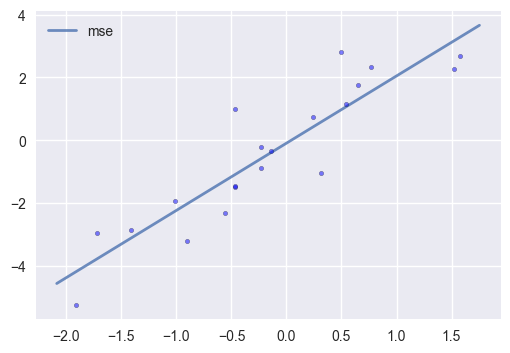

In [22]:
x,y=rand_data(20) # generate data
a,b=mse_fit_coefs(x,y) # do the fit

ax=plot_data(x,y) # plot the data
plot_fits(ax,(a,b,'mse')) # plot the fitted line

Good. Next, we do a MAE fit. Unfortunately, linear regression with MAE loss does not seem to be directly supported by *scikit-learn*. We'll use a somewhat ad-hoc implementation that seems to work well. I don't think this implementation should be used in a serious context, though.  

In [23]:
from scipy.optimize import minimize

def L1_loss(params,x,y):
    a,b=params
    return np.mean(np.abs(y-a*x-b))

def mae_fit_coefs(x,y):
    start=(0,0)
    result=minimize(L1_loss,start,args=(x,y))
    a,b=result.x
    return a,b

Next, we do both fits, and plot them both.

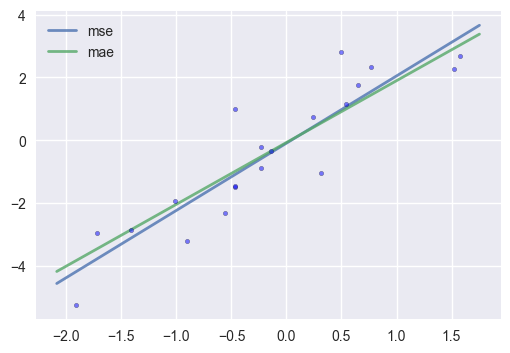

In [24]:
x,y=rand_data(20)

a2,b2=mse_fit_coefs(x,y)
a1,b1=mae_fit_coefs(x,y)

ax=plot_data(x,y)
plot_fits(ax,(a2,b2,'mse'),(a1,b1,'mae'))

We can also look at a histogram of the errors $(y-y^*)^2$ and $|y-y^*|$. We first need to compute them, and then we use a third, and last, convenience function <code>plot_errors</code>. As arguments <code>plot_errors</code> accepts *any* number of tuples <code>(errors,label)</code>, where <code>errors</code> contains a list of the errors and <code>label</code> is simply a string that describes the loss.

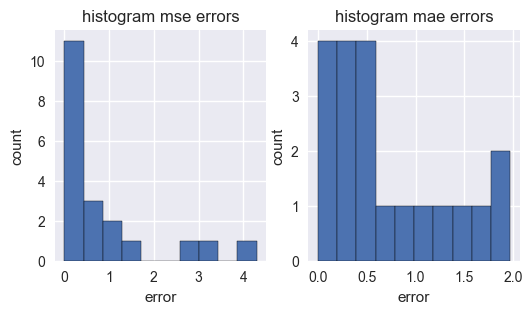

In [25]:
errors1=np.abs(y-a1*x-b1)
errors2=(y-a2*x-b2)**2
plot_errors((errors2,'mse'),(errors1,'mae'))

## Outliers

Let's see how outliers influence the fit.

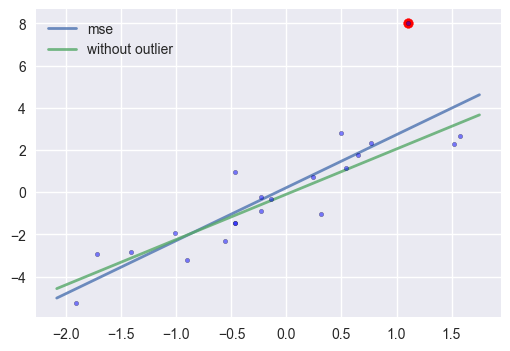

In [26]:
x_outlier,y_outlier=rand_data_outlier(20)

a2,b2=mse_fit_coefs(x_outlier,y_outlier)
a_clean,b_clean=mse_fit_coefs(x_outlier[:-1],y_outlier[:-1])

ax=plot_data(x_outlier,y_outlier)
ax.scatter([x_outlier[-1]],[y_outlier[-1]],color='r')
plot_fits(ax,(a2,b2,'mse'),(a_clean,b_clean,'without outlier'))


We see that the fit line moves towards the outlier (marked in red). Now it's your turn.

### Task: outlier
Fit a linear regression with *mse* loss, with *mae* loss and with *Huber* loss to the outlier data. A Huber regressor is provided by *scikit-learn*, see code below. Then plot the data as well as fitted lines. For the latter, use <code>plot_fits</code> (simply pass on three tuples as arguments).

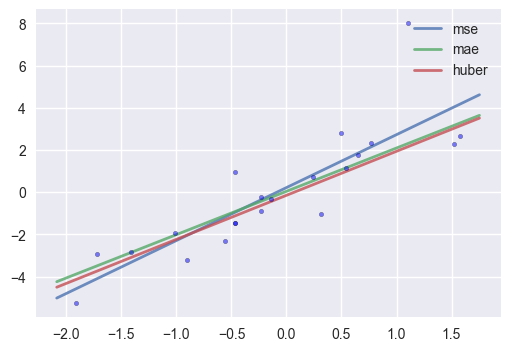

In [27]:
# The Huber regressor
from sklearn.linear_model import HuberRegressor

def huber_fit_coefs(x,y):
    huber=HuberRegressor()
    huber.fit(x.reshape(-1,1),y)
    a,b=*huber.coef_,huber.intercept_
    return a,b

### insert your code here ###
a_mse,b_mse = mse_fit_coefs(x_outlier,y_outlier)
a_mae,b_mae = mae_fit_coefs(x_outlier,y_outlier)
a_huber,b_huber = huber_fit_coefs(x,y)

ax=plot_data(x_outlier,y_outlier) # plot the data
plot_fits(ax,(a_mse,b_mse,'mse'),(a_mae,b_mae,'mae'),(a_huber,b_huber,'huber')) # plot the fitted line

### Task: outlier errors
For *mse* and for *mae* use <code>plot_errors</code> to plot the histogram of errors. Answer in one sentence: What can you observe that explains why the *mse* loss moves the fit line stronger towards the outlier?

### Answer: 
The one outlier results in a higher error in *mse* than in *mae* and thus has a larger effect on the minimizer.

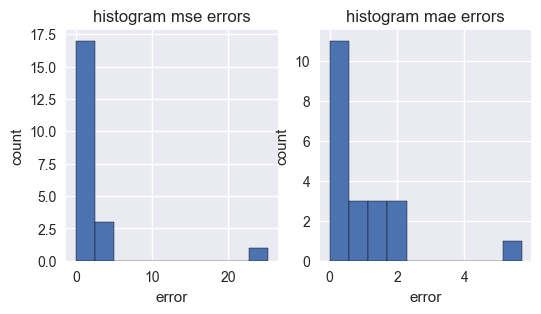

In [28]:
### insert your code here ###
errors_mae=np.abs(y_outlier-a_mae*x_outlier-b_mae)
errors_mse=(y_outlier-a_mse*x_outlier-b_mse)**2
plot_errors((errors_mse,'mse'),(errors_mae,'mae'))

## MAPE

I've also implemented linear regression with *mape* loss. Again, this is probably not an implementation intended for use in a production system.

In [29]:
def mape_loss(params,x,y):
    a,b=params
    return np.mean(np.abs(y-a*x-b)/y)

def mape_fit_coefs(x,y):
    start=(1,1)
    result=minimize(mape_loss,start,args=(x, y),method="Nelder-Mead")
    a,b=result.x
    return a,b

### Task: mape
Below do a fit with *mse* loss, and a fit with *mape* loss. For *mse*, store $a,b$ of the fitted line $ax+b$ in <code>a2,b2</code>, and for *mape* put them in <code>a_mape,b_mape</code>.

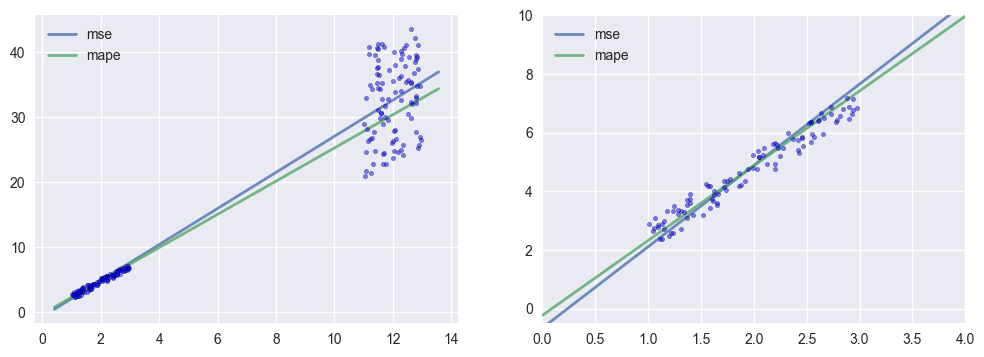

In [30]:
x,y=rand_data2(200)

### insert your code here ###

### end of insert ###

x,y=rand_data2(200)
fig,axs=plt.subplots(1,2,figsize=(12,4))
ax1,ax2=axs
a2,b2 = mse_fit_coefs(x,y)
a_mape,b_mape = mape_fit_coefs(x,y)
plot_data(x,y,ax=ax1)
plot_fits(ax1,(a2,b2,'mse'),(a_mape,b_mape,'mape'))

ax2.set_xlim(0,4)
ax2.set_ylim(-0.5,10)
plot_data(x,y,ax=ax2)
plot_fits(ax2,(a2,b2,'mse'),(a_mape,b_mape,'mape'))

### Task: mape errors
Using <code>plot_errors</code> plot a histogram of the *mse* and of the *mape* errors. Answer in at most three sentences: Which loss is more suitable here, and why?

### Anser:
The *mse* error seems to be the better choice. The histrograms show that the *mse* error takes into account that there is a sort of cloud that is fitted pretty well and another one that cannot be matched quite as well. In contrast, *mape* seems to be influenced in its entirety.

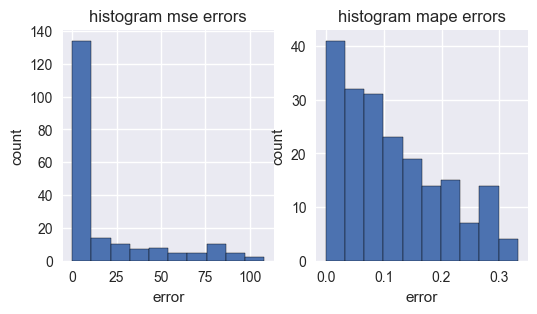

In [31]:
### insert your code here ###
errors_mape=np.abs(y-a_mape*x-b_mape)/y
errors_mse=(y-a2*x-b2)**2
plot_errors((errors_mse,'mse'),(errors_mape,'mape'))

### Task: More mape
* Do an *mse* fit, and store the fit parameters in <code>a2,b2</code>.
* Do a *mape* fit, and store the fit parameters in <code>a_mape,b_mape</code>.
* Plot the data and both fits.
* Plot the error histogram for both fits.
* Answer in at most three sentences: Which fit is better suited and why?

### Answer 
It is rather obvious that the *mse* fit is better suited, but what is going on with *mape*? The reason for the wonky fit is that some values are very close to zero, which results in a very large *mape* error (since we have to divide by a small value). Thus, *mape* regression tries to fit the small value to minimize the otherwise large error and doesn't really care about the overwhelming majority of points it misses. 

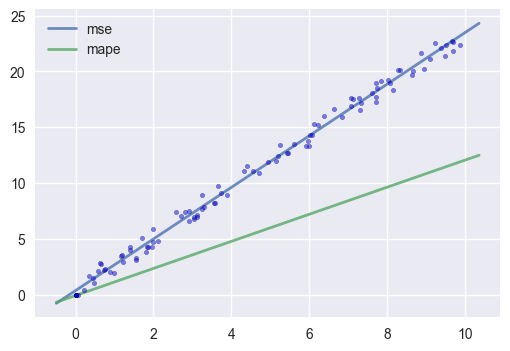

In [32]:
x,y=rand_data3(100,small=5)

### insert your code here ###
a2,b2 = mse_fit_coefs(x,y)
a_mape,b_mape = mape_fit_coefs(x,y)
ax=plot_data(x,y)
plot_fits(ax,(a2,b2,'mse'),(a_mape,b_mape,'mape'))

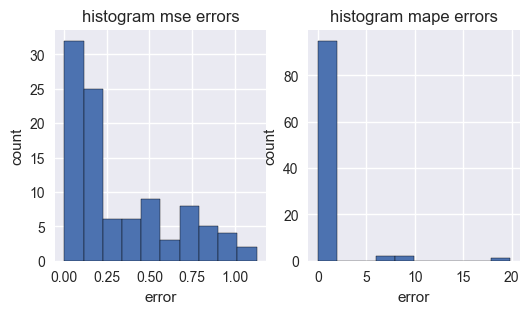

In [33]:
### insert your code here ###
errors_mape=np.abs(y-a_mape*x-b_mape)/y
errors_mse=(y-a2*x-b2)**2
plot_errors((errors_mse,'mse'),(errors_mape,'mape'))